# Generate the Planets Like in the Game

This creates png images that recreate each of the planets in Iridis Alpha.


In [69]:
from PIL import Image, ImageColor
ImageColor.getrgb("#AAFFEE")


(170, 255, 238)

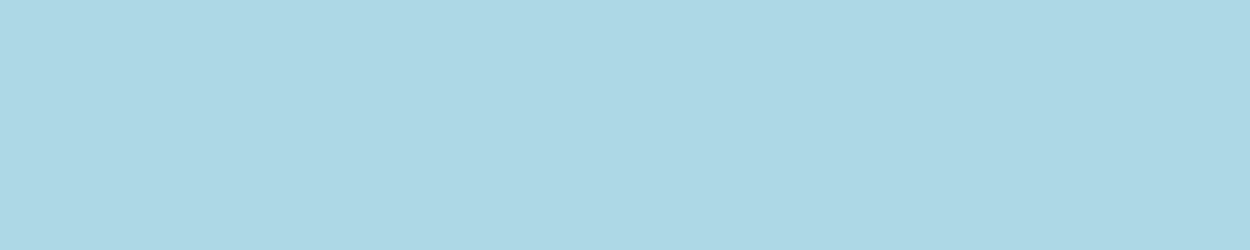

In [24]:

from PIL import Image, ImageColor

# PIL accesses images in Cartesian co-ordinates, so it is Image[columns, rows]
img = Image.new( 'RGB', (1250,250), "black") # create a new black image
pixels = img.load() # create the pixel map

for i in range(img.size[0]):    # for every col:
    for j in range(img.size[1]):    # For every row
        #pixels[i,j] = (i, j, 100) # set the colour accordingly
        pixels[i,j] = ImageColor.getrgb("lightblue") # set the colour accordingly
img

First we load the planet textures from the source code. Each character is stored from top left to bottom right.

In [33]:
import re
colors = {
    "00": 0,
    "01": 1,
    "10": 2,
    "11": 3,
}
charsets_files = ["../iridisalpha/src/graphics/planet_textures.asm"]
charsets = {}
for charsets_file in charsets_files:
    input_file = open(charsets_file,'r')
    charset_data = []
    curr_charset = []
    for l in input_file.readlines():
        if "CHARACTER" in l or "planet" in l:
            if charset_data:
                curr_charset += [charset_data]
            charset_data = []
        if "planet" in l:
            if curr_charset:
                charsets[charset_name] = curr_charset
            charset_name = l.strip()
            curr_charset = []
            continue

        m = re.findall(r"[0-1]{8}",l)
        if not m:
            continue
        bits = m[0]
        for i in range(0,7,2):
            bitpair = bits[i:i+2]
            charset_data += [colors[bitpair]]
            charset_data += [colors[bitpair]]
    if charset_data:
        curr_charset += [charset_data]
    charsets[charset_name] = curr_charset


In [73]:
background_color = 'black'
c64_to_rgb = {
"black": "#000000",     
"white": "#ffffff",     
"red": "#880000",       
"cyan":  "#aaffee",     
"violet": "#cc44cc",    
"purple": "#cc44cc",    
"green": "#00cc55",     
"blue":  "#0000aa",     
"yellow":  "#eeee77",   
"orange":  "#dd8855",   
"brown": "#664400",     
"lightred": "#ff7777",  
"darkgrey": "#333333",  
"grey":  "#333333",    
"grey2":  "#777777",    
"darkgray": "#333333",  
"gray":  "#333333",    
"gray2":  "#777777",    
"lightgreen": "#aaff66",
"lightblue":  "#0088ff",
"lightgrey": "#bbbbbb", 
"lightgray": "#bbbbbb", 
"grey3": "#bbbbbb",                             
"gray3": "#bbbbbb",                             
}

planet_colors = {
    'planet1Charset' : [background_color,'brown','lightblue','lightgreen'],
    'planet2Charset' : [background_color,'gray','lightred','brown'],
    'planet3Charset' : [background_color,'yellow','white', 'lightred'],
    'planet4Charset' : [background_color,'lightblue','yellow', 'darkgray'],
    'planet5Charset' : [background_color,'lightgreen','lightred','lightred'],
}

Get the structure data

In [36]:
raw_structure_data = """
mediumStructureData  .BYTE $65,$67,$69,$6B,$FF        
                     .BYTE $64,$66,$68,$6A,$FE        
largestStructureData .BYTE $41,$43,$51,$53,$41,$43,$FF
                     .BYTE $60,$60,$50,$52,$60,$60,$FF
                     .BYTE $49,$4B,$4D,$4F,$6D,$6F,$FF
                     .BYTE $48,$4A,$4C,$4E,$6C,$6E,$FE
nextLargestStructure .BYTE $59,$5B,$FF
                     .BYTE $58,$5A,$FF    
                     .BYTE $55,$57,$FF                
                     .BYTE $54,$56,$FE                
warpGateData         .BYTE $75,$77,$7D,$7F,$FF        
                     .BYTE $74,$76,$7C,$7E,$FF        
                     .BYTE $71,$73,$79,$7B,$FF        
                     .BYTE $70,$72,$78,$7A,$FE        
littleStructureData  .BYTE $45,$47,$FF
                     .BYTE $44,$46,$FE
"""
structure_data = {}
struct_chars = []
for l in raw_structure_data.split('\n'):
    if any(d in l for d in ["Data","Structure"]):
        if struct_chars:
            structure_data[struct_name] = struct_chars
        struct_name = l[:21].strip()
        struct_chars = [l[27:].strip().split(',')[:-1]]
        continue
    if "BYTE" in l:
        struct_chars += [l[27:].strip().split(',')[:-1]]
structure_data[struct_name] = struct_chars


Functions for creating the image png files in the `planets` subdirectory, with names like `charsetPlanet1_randomPlanet`.

In [112]:
from PIL import Image, ImageColor, ImageOps
BIT_WIDTH = 8

def fillCharacter(pixels, planet_color_scheme, c, 
                  byte_x_offset=0, byte_y_offset=0, grid_height=0):
    bit_y_offset = ((grid_height - (byte_y_offset * BIT_WIDTH))) - 1
    for j,v in enumerate(c):
        if not v:
            continue
        x = (byte_x_offset * BIT_WIDTH) + ((j % BIT_WIDTH) if j >= 7 else j)
        y = (bit_y_offset - int(j/BIT_WIDTH)) if j >= 7 else bit_y_offset
        color = planet_color_scheme[int(v)]
        pixels[x,y] = ImageColor.getrgb(c64_to_rgb[color])
    return pixels

def createStructure(pixels, planet_color_scheme, planet_name, scene):
    grid_width = BIT_WIDTH * len(scene[0])
    grid_height = BIT_WIDTH * len(scene)

    charset = charsets[planet_name]
    for byte_y_offset,ln in enumerate(scene):
        for byte_x_offset,hex_ref in enumerate(ln):
            char_index = int(hex_ref[1:],16) - 0x40
            if char_index < 0:
                continue
            c = charset[char_index]
            pixels = fillCharacter(pixels, planet_color_scheme,
                                   c, byte_x_offset, byte_y_offset, grid_height)
    return pixels

def splitAndStackImage(img):
    # Split the image into 2 sections
    plates = range(0,4)
    stacked_img = Image.new(
        'RGBA',
        (int(img.width / len(plates)), # width
         (img.height * len(plates)) + (50 * len(plates))), # height
        (255, 0, 0, 0))
    for i in plates:
        # im1 = im.crop((left, top, right, bottom))
        stacked_img.paste(
            img.crop((i * stacked_img.width, 0, 
                      (i * stacked_img.width) + stacked_img.width,
                      img.height)),
            (0, (i * img.height) + (50 * i)))
    stacked_img.resize((stacked_img.width * 10, stacked_img.height * 10), Image.NEAREST)
    return stacked_img

def generateScene(scene, step):
    for planet_name in planet_colors:
        # PIL accesses images in Cartesian co-ordinates, so it is Image[columns, rows]
        img = Image.new( 'RGBA', (SCENE_WIDTH * BIT_WIDTH, HEIGHT * BIT_WIDTH),
                        (255, 0, 0, 0)) # create a new transparent image
        pixels = img.load() # create the pixel map
        planet_color_scheme = planet_colors[planet_name]
        pixels = createStructure(pixels, planet_color_scheme, 
                                 planet_name, scene)
        img = ImageOps.flip(img)

        # Split the image into 2 sections
        stacked_img = splitAndStackImage(img)
        file_name = f"../src/planets/{planet_name}_Random_Step{step}.png"
        stacked_img.save(file_name)



Generate the planet following the steps in GenPlan as closely as possible.

In [123]:
import copy
import random

SCENE_WIDTH = 256
HEIGHT = 4

# The template for each planet has the sea as its surface.
blank_scene = []
for y in range(0,HEIGHT):
    l = []
    for x in range(0,SCENE_WIDTH,2):
        l += ["$40","$42"] if y == 0 else ["$00","$00"]
    blank_scene += [l]

# Generate pngs with the sea.
generateScene(list(reversed(blank_scene)), step=1)

land_start = random.randint(0,128)
land_length = random.randint(0,128)
land_length += 32

# The left shore of the land
for i, v in enumerate(['$5C','$5E']):
    blank_scene[0][land_start + i] = v

# Fill the land
for i in range(land_start+2, land_start+land_length, 2):
    blank_scene[0][i] = '$41'
    blank_scene[0][i+1] = '$43'

# The right shore of the land
for i, v in enumerate(['$5D','$5F']):
    blank_scene[0][land_start + land_length + i] = v

# Generate pngs with the sea and land.
generateScene(list(reversed(blank_scene)), step=2)

# Add a random structure every 13 to 29 bytes.
random_struct_list = [s for s in structure_data.keys() if "warp" not in s]
struct_offset = random.randint(13,29)
while struct_offset < SCENE_WIDTH - 25:
    random_struct_name = random_struct_list[random.randint(0,3)]
    random_struct = structure_data[random_struct_name]
    for i,v in enumerate(random_struct):
        for j,b in enumerate(v):
            blank_scene[i][struct_offset+j] = b
    struct_offset += random.randint(13,29)

# Generate pngs with the structures added.
generateScene(list(reversed(blank_scene)), step=3)

# Add the warp gates at the beginning and end
for struct_offset in [4,251]:
    random_struct = structure_data["warpGateData"]
    for i,v in enumerate(random_struct):
        for j,b in enumerate(v):
            blank_scene[i][struct_offset+j] = b

# Generate pngs with the warp gates added.
generateScene(list(reversed(blank_scene)), step=4)

blank_scene = list(reversed(blank_scene))


In [ ]:
# Render a full randomly generated surface
header = """
\\begin{figure}[H]                          
{                                          
  \\setlength{\\tabcolsep}{3.0pt}            
  \\setlength\cmidrulewidth{\lightrulewidth}
"""

for planet_name in planet_colors:
    figure = header
    # PIL accesses images in Cartesian co-ordinates, so it is Image[columns, rows]
    img = Image.new( 'RGBA', (SCENE_WIDTH * BIT_WIDTH, HEIGHT * BIT_WIDTH),
                    (255, 0, 0, 0)) # create a new transparent image
    pixels = img.load() # create the pixel map
    planet_color_scheme = planet_colors[planet_name]
    pixels = createStructure(pixels, planet_color_scheme, 
                             planet_name, blank_scene)
    img = ImageOps.flip(img)
    
    # Split the image into 2 sections
    stacked_img = splitAndStackImage(img)
    file_name = f"../src/planets/{planet_name}_Random.png"
    stacked_img.save(file_name)
    
    figure += "\\begin{subfigure}{1.0\\textwidth}\n"
    figure += f"\\surface{{{planet_name}_Random}}\n"
    figure += "\\end{subfigure}\n"

    footer = f"""
    }}\\caption[]{{Randomly Generated: {planet_name}}}
    \\end{{figure}}
    """
    figure += footer
    of_name = f"../src/planets/{planet_name}_randomly_generated.tex"
    with open(of_name,'w') as output_file:
        output_file.write(figure)
    print(f"\subfile{{planets/{planet_name}_randomly_generated}}")



Generate single screen images of upper planet surface

In [ ]:
planetName = 
# PIL accesses images in Cartesian co-ordinates, so it is Image[columns, rows]
img = Image.new( 'RGBA', (40 * BIT_WIDTH, 25 * BIT_WIDTH),
                (255, 0, 0, 0)) # create a new transparent image
pixels = img.load() # create the pixel map
planet_color_scheme = planet_colors[planet_name]
pixels = createStructure(pixels, planet_color_scheme, 
                         planet_name, scene)
img = ImageOps.flip(img)

# Split the image into 2 sections
stacked_img = splitAndStackImage(img)
file_name = f"../src/planets/{planet_name}_Random_Step{step}.png"
stacked_img.save(file_name)
